# COGS 108 - Final Project 

# Overview

Our project aims to investigate the relationship between different factors that relate to a state's wellbeing (such as GDP, insurance rates, and teen birth rates) and the state's suicide rate. We believe that low GDP and high teen prenancy rates will be associated with higher suicide rates. However, even if we find such associations, it will be hard to find a clear cause and effect. In order to futher tease apart the relationship between these factors, we will also run some multi-variable regression to see which factors have the most predictive power. 

# Names

- Shane Nielsen
- Stephen Cheung
- Humza Ali
- Ye Lin
- Chufan Yang

#### Group Members IDs

- A14749485
- A15692431
- A11868836
- A15349617
- A14733456

# Research Question

Is there a relationship between teen birth rates, state GDP, and insurance rates of a state and suicide rates?

## Background and Prior Work

Our interest in this question stemmed from an awareness of the growing issue of mental health on college campuses. We were interested in studying something that would be relevant to us and our society at large. We came upon some data regarding suicide rates for countries, and initially wanted to compare country GDP to country suicide rates to see if there was a relationship. However, due to the lack of data that could be found. We eventually settled on comparing US states' suicide rates against the factors that have been listed above. 

We were only able to find studies that compared countries GDP and their suicide rates, but not any that compared states by their GDP and suicide rates (1). We found some studies that found a relationship between mental health care access and suicide rates, while others did not, (2) so it doesn't seem like there is a clear answer. However, we are still interested in seeing which variables have the biggest impact for our analysis. Overall, we are excited to see which factors will have the highest link to suicide rates, so we are using multivariable regression to see which factors might be confounding variables. 

We think this is important because it will help tease apart the different relationships between a variety of factors to see how they lead to an increase in suicide rates. Any way to further our understanding of the different factors at play, (causally linked or not) will help us deal with our current mental health care crisis. 

References (include links):
- 1) https://bmjopen.bmj.com/content/2/3/e000785
- 2) https://www.rand.org/research/gun-policy/analysis/essays/mental-health-access-and-suicide.html

# Hypothesis


Our hypothesis is that lower GDP, higher uninsured rates, and higher teen birth rates will be associated with higher suicide rates. 

# Dataset(s)

- Dataset Name: GDP per capita in US states
- Link to the dataset: https://www.kaggle.com/solorzano/gdp-per-capita-in-us-states/downloads/gdp-per-capita-in-us-states.zip/1
- Number of observations: 60

The Real GDP Per Capita in chained 2009 dollars per state for 2013 to 2017. Real GDP per capita is a measurement of the total economic output of a country divided by the number of people and adjusted for inflation. It's used to compare the standard of living between countries and over time.


- Dataset Name: Suicide Mortality Rate per State for 2014-2016
- Link to the dataset: https://www.cdc.gov/nchs/pressroom/sosmap/suicide-mortality/suicide_mortality.csv
- Number of observations: 250 

The number of suicide deaths per 100,000 total population per state. It is age adjusted for age-distribution and population size. It has data for 2005, 2014, 2015 and 2016 for US states excluding US territories.


- Dataset Name: Uninsured Percentage Rate per State for 2014-2016
- Link to the dataset: https://www.cdc.gov/nchs/pressroom/sosmap/nhis_insured/nhis_insured.csv
- Number of observations: 250

An estimated percentage of uninsured people per state for all ages. It has data for 2005, 2014, 2015 and 2016 for US states excluding US territories.

- Dataset Name: Teen Birth Rate per State for 2014-2016
- Link to the dataset: https://www.cdc.gov/nchs/pressroom/sosmap/teen-births/teen_births.csv
- Number of observations: 250

The number of live births per 1000 females aged 15-19 for US states excluding US territories. It has data for 2005, 2014, 2015 and 2016.

# Setup

Importing libraries and importing data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import patsy
import statsmodels.api as sm
import scipy.stats as stats

# https://www.kaggle.com/solorzano/gdp-per-capita-in-us-states
# GDP per state

df_gdp = pd.read_csv('bea-gdp-by-state.csv')

df_gun_ownership = pd.read_csv('raw-thoughtco-guns-by-state.txt', sep='\t')

df_suicide_rates = pd.read_csv('suicide_mortality.csv')

df_teen_births = pd.read_csv('teen_births.csv', sep=',')

df_uninsured_rates = pd.read_csv('nhis_insured.csv', sep=',')


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

For data cleaning our data does not have any identifiers listed by the Safe Harbor Method. We mainly need to combine all of our data and remove any unnecessary data.

1. The bea-gdp-by-state.csv has states and extra regions in it's area column. We only want data concerning states only. I created a nullifyNonStateArea function which returns null if the string passed to it is not a state. By applying this function to the gdp dataframe, I can change all the data that we don't need to None. Then we can drop all those data.

2. The suicide_mortality.csv, teen_births.csv and nhis_insured.csv had extra unnecessary columns such as URL and an Unnamed Column because of how the csv file had a trailing comma at the end of each line. We can just drop the columns.

3. The nhis_insured.csv also has a missing row for wyoming 2016. We added a row to the dataframe with NaN uninsured rate, so the data lines up.

4. Next we just have to rename columns to make them more descriptive and merge each dataframe by state and year. However, one problem was that the gdp dataframe columns and rows were reversed, so we had to use pd.melt to convert the year columns to rows.

5. Another issue was that the gdp dataframe year column had a different datatype than the merged dataframe, so that had to be converted in order to merge them together.

6. At the end, we decided to removed the state and year that have any NaN values because we cannot perform regressions on those values and we do not want to just set them to 0 because it may skew the predictory lines. Also during the merging of dataframes, District of Columbia was also removed because of not all data files included District of Columbia.


In [2]:
def abbreviationToState(abbreviation):
    states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
    }
    
    if abbreviation in states:
        return states[abbreviation]
    else:
        return abbreviation

def nullifyNonStateArea(area):
    states = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
    }
    
    if area in states:
        return area
    else:
        return None

#Removing unneccesary data

#removing Areas that are not states
df_gdp["STATE_NAME"]= df_gdp['Area'].apply(nullifyNonStateArea)
df_gdp = df_gdp.dropna()
df_gdp = df_gdp.drop(['Area'], axis=1)

#removing District of Columbia, since we want to make it consistent among all data
df_gun_ownership["STATE_NAME"] = df_gun_ownership['State'].apply(nullifyNonStateArea)
df_gun_ownership = df_gun_ownership.dropna()
df_gun_ownership = df_gun_ownership.drop(['Rank', 'State'], axis=1)

#removing URL and Unnamed Column
df_teen_births = df_teen_births.drop(['URL', 'Unnamed: 4'], axis=1)
df_uninsured_rates = df_uninsured_rates.drop(['URL', 'Unnamed: 4'], axis=1)
df_suicide_rates = df_suicide_rates.drop(['URL'], axis=1)

#The insured rate datasource is missing Wyoming, so adding a NaN Insured Rate
df_uninsured_rates = df_uninsured_rates.append({"YEAR": 2016, "STATE": "WY"}, ignore_index = True)

#Merging mulitple data sets together by STATE and YEAR
df = pd.merge(df_uninsured_rates,
              df_teen_births[['STATE', 'YEAR', 'RATE']],
              on=['STATE', 'YEAR'])

df = pd.merge(df,
              df_suicide_rates[['STATE', 'YEAR', 'RATE']],
              on=['STATE', 'YEAR'])

#Renaming columns for easier description
df = df.rename(index=str, columns={"RATE_x": "UNINSURED_RATE", "RATE_y": "TEEN_BIRTH_RATE", "RATE": "SUICIDE_RATE"})

#Creating STATE_NAME Column by converting STATE Abbreviations
df["STATE_NAME"] = df["STATE"].apply(abbreviationToState)

#Converts columns to rows, for easier merging of datasets
df_gdp = pd.melt(df_gdp, id_vars =['STATE_NAME'], value_vars =['2014', '2015', '2016'])

#Renaming columns so easier description
df_gdp = df_gdp.rename(index=str, columns={"variable": "YEAR", "value": "GDP"})

#Need this because cannot merge on different types
df_gdp['YEAR'] = df_gdp['YEAR'].astype(int)

#Merging base dataframe and gdp dataframe by STATE and YEAR
df = pd.merge(df,
              df_gdp[['STATE_NAME', 'YEAR', 'GDP']],
              on=['STATE_NAME', 'YEAR'])

df = df.dropna(how='any')


# Data Analysis & Results

                            OLS Regression Results                            
Dep. Variable:           SUICIDE_RATE   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     31.64
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           9.44e-08
Time:                        18:14:08   Log-Likelihood:                -397.93
No. Observations:                 145   AIC:                             799.9
Df Residuals:                     143   BIC:                             805.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.9275      1.002     

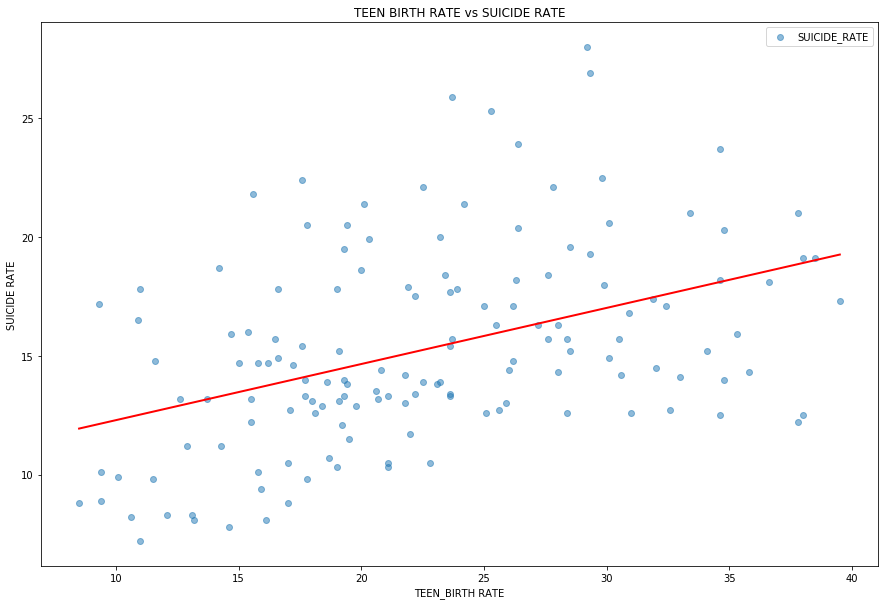

In [3]:
#Get sucide rate and teen birth rate
df_suicide = df['SUICIDE_RATE']
df_teen = df['TEEN_BIRTH_RATE']

#fit the single variable model using OLS regression
(outcome_1,predictors_1) = patsy.dmatrices("SUICIDE_RATE ~ TEEN_BIRTH_RATE",df)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

#plot scatter plot for teen birth rate vs suicide rate
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_teen, df_suicide, alpha=0.5, color='C0')

#plot prediction line using the model
x_pred = np.linspace(df_teen.min(), df_teen.max(), 50)
x_pred2 = sm.add_constant(x_pred)
y_pred = res_1.predict(x_pred2)
ax.plot(x_pred, y_pred, '-', color='red', linewidth=2)

plt.title('TEEN BIRTH RATE vs SUICIDE RATE')
plt.ylabel('SUICIDE RATE')
plt.xlabel('TEEN_BIRTH RATE')
plt.legend();


In our initial analysis, we ran a regression on the teen birth rate data. In our regression, the p value was below 0.05, so we reject the null hypothesis and we conclude that there is a significant correlation between teen birth rates and suicide. However, the R^2 value is low, so this indicates that teen birth rate is not a very strong predictor. This can also been visually by inspecting the graph above, where all of the points are spread out along the line, indicating a high level of variability. 

                            OLS Regression Results                            
Dep. Variable:           SUICIDE_RATE   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     19.43
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           2.04e-05
Time:                        18:14:09   Log-Likelihood:                -403.19
No. Observations:                 145   AIC:                             810.4
Df Residuals:                     143   BIC:                             816.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.6911      0.877     13.

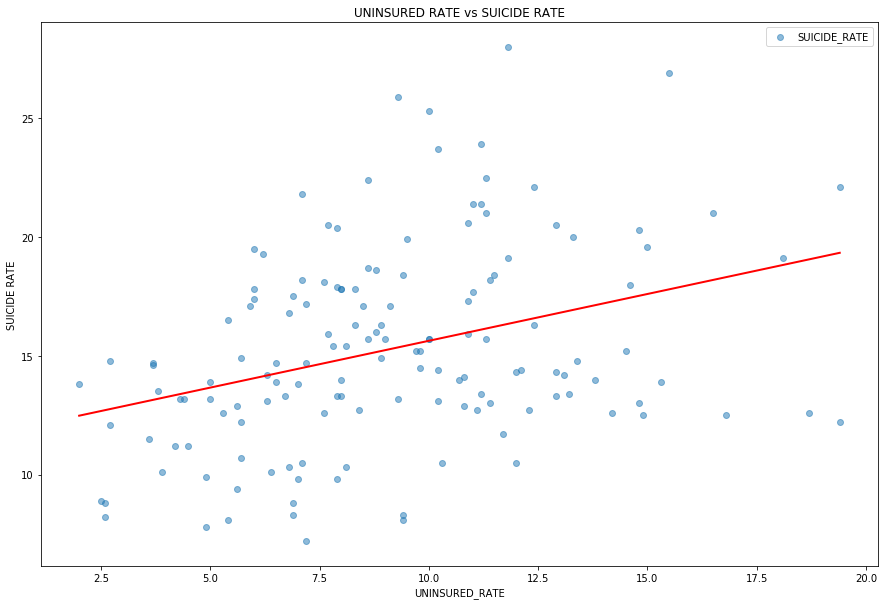

In [4]:
#Get uninsured rate
df_uninsured = df['UNINSURED_RATE']

#fit the single variable model using OLS regression
(outcome_2,predictors_2) = patsy.dmatrices("SUICIDE_RATE ~ UNINSURED_RATE",df)
mod_2 = sm.OLS(outcome_2,predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

#plot scatter plot for uninsured rate vs suicide rate
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_uninsured, df_suicide, alpha=0.5, color='C0')

#plot prediction line using the model
x_pred = np.linspace(df_uninsured.min(), df_uninsured.max(), 50)
x_pred2 = sm.add_constant(x_pred)
y_pred = res_2.predict(x_pred2)
ax.plot(x_pred, y_pred, '-', color='red', linewidth=2)

plt.title('UNINSURED RATE vs SUICIDE RATE')
plt.ylabel('SUICIDE RATE')
plt.xlabel('UNINSURED_RATE')
plt.legend();


In our next analysis, we ran a regression on the uninsured rate. In our regression, the p value was again below 0.05, so we reject the null hypothesis and we conclude that there is a  correlation between insurance rates and suicide. However, the R^2 value is low, so this indicates that the insured rate is a not a strong predictor either. 

                            OLS Regression Results                            
Dep. Variable:           SUICIDE_RATE   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     20.56
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           1.21e-05
Time:                        18:14:10   Log-Likelihood:                -402.69
No. Observations:                 145   AIC:                             809.4
Df Residuals:                     143   BIC:                             815.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.3685      1.814     12.883      0.0

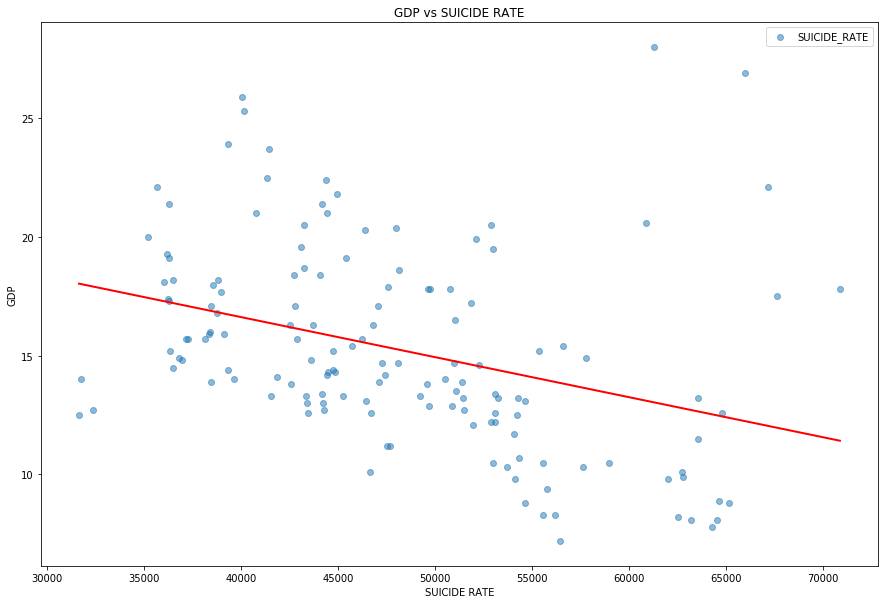

In [5]:
#Get GDP
df_GDP = df['GDP']

#fit the single variable model using OLS regression
(outcome_3,predictors_3) = patsy.dmatrices("SUICIDE_RATE ~ GDP ",df)
mod_3 = sm.OLS(outcome_3,predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

#plot scatter plot for GDP vs suicide rate
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_GDP, df_suicide, alpha=0.5, color='C0')

#plot prediction line using the model
x_pred = np.linspace(df_GDP.min(), df_GDP.max(), 50)
x_pred2 = sm.add_constant(x_pred)
y_pred = res_3.predict(x_pred2)
ax.plot(x_pred, y_pred, '-', color='red', linewidth=2)

plt.title('GDP vs SUICIDE RATE')
plt.xlabel('SUICIDE RATE')
plt.ylabel('GDP')
plt.legend();

In our final regression, we compared the suicide rates to the GDP for each state, and we found again that the p value was below .05, but the R^2 value is very low, so there is a correlation, but it should not be considered a strong predictor. 

In [6]:
#fit the multi variable model using OLS regression
(outcome_4,predictors_4) = patsy.dmatrices("SUICIDE_RATE ~ TEEN_BIRTH_RATE \
                                           + UNINSURED_RATE + GDP ",df)
mod_4 = sm.OLS(outcome_4,predictors_4)
res_4 = mod_4.fit()
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:           SUICIDE_RATE   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     12.98
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           1.55e-07
Time:                        18:14:10   Log-Likelihood:                -394.75
No. Observations:                 145   AIC:                             797.5
Df Residuals:                     141   BIC:                             809.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.9086      2.742     


In our multivariate regression, we can understand why the R^2 value was so low for each individual factor. Here we have different p values for each one, with low ones for teen birth rate and GDP, which indicates that those two variables both have a relationship to the overall suicide rate. GDP has a negative coefficient, which means that the lower the GDP is, the higher the suicide rate is, which indicates that poor states actually have higher suicide rates, which is what we predicted. The teen birth rate and uninsured rate has positive influence on the overall suicide rate, which indicates that they are positive correlated with high suicide rates, althought the effect is not too strong. Overall, we can conclude that GDP is the strongest factor out of the ones that we analyzed, followed by teen birth rate, and then in last place is the uninsured rate.


# Ethics & Privacy

There are a variety of ethical and privacy issues that surround our topic of choice. The first glaring issue is that suicide rates have varying levels of accuracy, as some suicides are not reported as suicides, while other cases might involve what seems like suicide but it could be due to some other issue. Different states have different guidelines regarding what is considered "suicide", so directly comparing data from different states could be comparing vastly different statistics and the results might not be very accurate. Also, some populations, like illegal immigrants or marginalized individuals in society might not always report suicides to the government or other institutions, so their data might not be included in our data set.

Regarding permissions, the suicide data was released by different state governments and compiled by a team on kaggle, so it seems to be safe to use.

An interesting ethical issue regarding suicide rate data is that none of the individuals were able to consent to their data being released, as suicide data is captured by governmental organizations after someone already commits suicide. In this case there is no way to get their consent, as they have already passed away. Luckily, our data does not have any personally identifiable information, other than state and year of death, so it would be hard to use the data to figure out who the individuals in the data really are.

Another ethical issue is that the results of our data could be spuriously used to imply casusation between factors that might not be accurate. Someone nefarious could use the results of our work to push certain policies or agendas of their own. This would be very unfortunate. Any relationships we find between different variables and suicide rates does not imply any sort of direct casual link between the two factors, but in our modern day news cycle, length studies and analysis of data are boiled down to a few key sentences that are then spread as talking points for the entire news media. Any confounding variable that we did not factor into our analysis could cause fake relationships to show up.

Another issue that arises when studying suicide is that "certain types of news coverage can increase the liklihood of suicide in vulnerable individuals" (https://www.nami.org/Blogs/NAMI-Blog/June-2018/Why-Suicide-Reporting-Guidelines-Matter). This means that the simple reporting of the results of our data could lead to people committing suicide, if the media reports are not careful in what they say.

For most of these issues, we do not have a clear cut solution. The issues with suicide data are not things we can easily overcome with our resources, so the best we can do is be very cautious in our analysis and not allow any random correlation convince us that there is a clear cut relationship between the two factors.

# Conclusion & Discussion

Our project investigated how suicide rates relate to the residents' well-being of each state, in order to figure out what factors cause higher suicide rate of a state. The factors that we are studying are teen birth rates, state GDP, and insurance rates of each state in the US. We believe that lower GDP, higher uninsured rates, and higher teen birth rates will be associated with higher suicide rates. According to our result and analysis, it shows the same as what we expected, and we also concluded that GDP is the strongest factor out of the ones that we analyzed, followed by teen birth rate, and in last place is uninsured rate.

In conclusion, GDP seems to have the most significant effect on suicide rates. However, we think that our analysis should examine more factors in order to get a bigger picture understanding of all of the different forces at play when it comes to a state's suicide rate. As the number of factors increases, the power of our multivariable regression to tease apart the different factors will increase, so we can get a better model that takes into account all of the complicated forces in our modern day world. In our limited analysis, we were able to compare the influences of a few different factors, but we hope to follow this up with a larger scale study someday. Our current results do not mean that much, as we outlined in the ethics and privacy section all of the pitfalls associated with our current approach. 